# Pre-processing

In [1]:
import keras
import numpy as np 
import pandas as pd

Using TensorFlow backend.


In [2]:
# coding: utf-8
# from settings import training_directory
import xml.etree.ElementTree as ET
from os.path import join as pjoin



"""
Script to transform word.xml into word.csv
"""
training_directory = ""

tree = ET.parse(pjoin(training_directory, 'word.xml'))
root = tree.getroot()

list_file = []
list_tag = []

for child in root:
    list_file.append(child.attrib["file"])
    list_tag.append(child.attrib["tag"])

data = pd.DataFrame({"file":list_file, "tag": list_tag})

data.to_csv(pjoin(training_directory, "word.csv"), sep=";", encoding="utf8")


In [3]:
from skimage.transform import resize
from skimage.io import imread 
from skimage.color import rgb2grey
import os

#  Attention : à faire seulement la première fois, une fois que les images ont la bonne dimension, plus besoin de le faire
# training_directory = ""

# """
# Script to resize all pictures of ICDAR dataset
# """

# word = pd.read_csv(os.path.join(training_directory, "word.csv"), sep=";", index_col=0)

# for file in word.file:
#     path_img = os.path.join(training_directory, str(file))
#     img = imread(path_img)
#     print(img.shape)
#     img_reshaped = resize(image= img, output_shape=(32, 100, 1))
#     np.save(os.path.join(training_directory,file[:-4]+"_reshaped.npy"),img_reshaped)

In [4]:
def process_target_model_1(target, dict_conversion):
    """
    Change a list of labels into a list of list of number
    """

    list_target = []
    
    for tag in target:
        temp = list(tag)
        temp = [dict_conversion[char.lower()] for char in temp if char.lower() in "abcdefghijklmnopqrstuvwxyz0123456789"] 
        while len(temp) != 23:
            temp.append(36)
        list_target.append(temp)

    return np.array(list_target)


def create_conversion_model1():
    """
    Create the dictionnay to convert a character into its position in the output of model 1
    """
    dict_conversion = {}
    for i, char in enumerate("abcdefghijklmnopqrstuvwxyz0123456789_"):
        dict_conversion[char] = i
    return dict_conversion


def process_file_name(file_names, shape=(1, 32, 100, 1)):
    """
    From a list of file_name, load all the pictures in memory
    """
    firststep = True
    for file_name in file_names:
        temp_name = file_name.split(".")
        temp_name = pjoin(training_directory, "".join(temp_name[:-1] + ["_reshaped.npy"]))
        if firststep:
            list_file = np.load(temp_name).reshape(shape)
            firststep = False
        else:
            list_file = np.vstack((list_file, np.load(temp_name).reshape(shape)))
    return list_file

In [5]:
from sklearn.model_selection import train_test_split
def preprocess_data(folder, n_model=1, shape=(1, 32, 100, 1)):
    """
    From a folder number (or None for all folders) and the number of the model, return a 
    training and a testing set
    """ 
        
    list_file = process_file_name(folder.file, shape)

    if n_model == 1:
        dict_conversion = create_conversion_model1()
        list_target = process_target_model_1(folder.tag, dict_conversion)
    elif n_model == 2:
        list_ngrams = get_ngrams()
        dict_conversion = get_dict_ngrams(list_ngrams)
        list_target = process_target_model_2(folder.tag, dict_conversion)
    elif n_model == 3:
        list_target = np.array(folder.tag)
    else:
        raise ValueError

    train_file, test_file, train_target, test_target = train_test_split(list_file, list_target)
    
    return train_file, test_file, train_target, test_target 

In [6]:
train_file, test_file, train_target, test_target = preprocess_data(folder = data)
print("input shape : ", train_file.shape) #pb : pourquoi la taille est elle initialisée à 32 * 32 *1 et non 100 * 32 *1 ?
print("target shape : ", train_target.shape)

input shape :  (867, 32, 100, 1)
target shape :  (867, 23)


In [11]:
23*37

851

In [67]:
from keras.utils import to_categorical
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

encoded_target = encode(train_target)
print(encoded_target.shape)
nb_lettres_max = 5

dim = 37*nb_lettres_max
reshape_data = np.zeros((867, dim))
for i in range (867):
    reshape_data[i,:dim] = encoded_target[i,:nb_lettres_max,:].flatten()
print (reshape_data.shape)
print(reshape_data[3])

# test = encoded_target.transpose(1,0,2)
# # print(test.shape)
# # print(test[22,:,:])

# target = []
# for i in range(23):
#     target.append(test[i,:,:])

# print(target[0].shape)
# print(target[0])

Shape of data (BEFORE encode): (867, 23)
Shape of data (AFTER  encode): (867, 23, 37)

(867, 23, 37)
(867, 185)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# CNN

In [98]:
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, Activation, Flatten, Dense, Dropout
from keras.models import Model

input_img = Input(shape=(32, 100, 1))


x = Conv2D(filters = 64, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(input_img)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 128, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 256, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 512, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 512, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
x = Flatten(data_format=None)(x)
x = Dropout(0.2)(x)
x = Dense(units = 4096, activation = "relu")(x)
x = Dropout(0.2)(x)
x = Dense(units = 4096)(x)

drop = [Dropout(0.2)(x) for i in range (nb_lettres_max)]
towers = [Dense(units = 37, activation='softmax')(drop[i]) for i in range (nb_lettres_max)]
output = concatenate(towers, axis = -1)

In [99]:
char = Model(input=input_img, output=output)

C:\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  """Entry point for launching an IPython kernel.


In [100]:
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=True)
char.compile(optimizer = sgd, 
             loss = 'binary_crossentropy', 
             metrics=['binary_accuracy'], 
             loss_weights=None, 
             sample_weight_mode=None)#categorical_crossentropy

In [71]:
char.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 32, 100, 64)  1664        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 16, 50, 64)   0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 16, 50, 128)  204928      max_pooling2d_16[0][0]           
__________________________________________________________________________________________________
max_poolin

In [101]:
from keras.callbacks import History 
history = History()
x = train_file
y = reshape_data

history = char.fit(x, y, batch_size=32, nb_epoch=100, verbose=1, callbacks=[history], validation_split=0.05, validation_data=None, shuffle=True, class_weight=None, sample_weight=None)

C:\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 823 samples, validate on 44 samples
Epoch 1/100
823/823 [==============================] - 170s 206ms/step - loss: 0.1232 - binary_accuracy: 0.9730 - val_loss: 0.1216 - val_binary_accuracy: 0.9730
Epoch 2/100
823/823 [==============================] - 149s 181ms/step - loss: 0.1102 - binary_accuracy: 0.9726 - val_loss: 0.1076 - val_binary_accuracy: 0.9730
Epoch 3/100
823/823 [==============================] - 146s 177ms/step - loss: 0.1043 - binary_accuracy: 0.9726 - val_loss: 0.1064 - val_binary_accuracy: 0.9730
Epoch 4/100
823/823 [==============================] - 133s 162ms/step - loss: 0.1035 - binary_accuracy: 0.9728 - val_loss: 0.1058 - val_binary_accuracy: 0.9730
Epoch 5/100
823/823 [==============================] - 168s 204ms/step - loss: 0.1031 - binary_accuracy: 0.9728 - val_loss: 0.1047 - val_binary_accuracy: 0.9730
Epoch 6/100
823/823 [==============================] - 148s 180ms/step - loss: 0.1029 - binary_accuracy: 0.9727 - val_loss: 0.1048 - val_binary_accura

In [96]:
char.save_weights("CHAR_100ep_3drop_5l.h5")

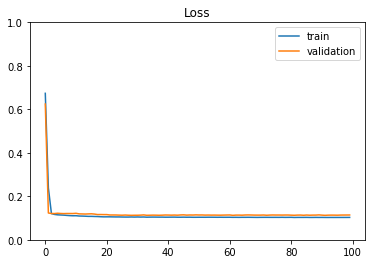

In [105]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.title('Loss');
plt.show()

In [83]:
from keras.applications.imagenet_utils import decode_predictions
pred = char.predict(test_file)
# print(decode_predictions(pred))

In [91]:
reshaped_pred = np.zeros((289,5,37))
for i in range (289):
    for j in range (5):
        reshaped_pred[i,j] = pred[i,j*37:37*(j+1)]
        print (reshaped_pred[i,j])
# Il y a bien sur des manières beaucoup plus propre de faire cela mais j'ai déjà eu plusieurs surprises avec le reshape
# Je le fait donc manuellement pour le moment, une fois qu'on aura de bons résultats, je le ferais plus proprement.

[4.32165137e-07 1.03808837e-08 9.12846243e-09 8.63794386e-01
 1.87459463e-07 5.47803625e-09 4.93643165e-05 2.46735825e-03
 1.65603573e-10 9.27371613e-04 6.19344078e-08 5.80503867e-09
 3.43895179e-09 6.34774096e-07 6.80659115e-02 1.01503861e-06
 1.63084643e-10 1.39258168e-06 2.78277090e-09 1.22641481e-07
 1.23823236e-06 1.26132305e-08 6.46861047e-02 1.33035257e-06
 3.12740241e-07 2.87329289e-08 2.32884573e-10 1.58688743e-10
 1.61096148e-06 4.28235503e-11 1.02455795e-06 1.17715828e-07
 2.07478992e-10 6.12963547e-09 1.00421529e-08 8.41320402e-10
 1.78094695e-08]
[9.64033475e-09 1.55610951e-06 1.43279236e-10 7.30809552e-06
 1.59157658e-04 2.19538721e-04 9.47912113e-08 2.40879831e-06
 1.60663165e-02 6.29984561e-06 5.58959982e-06 4.73093769e-06
 1.29172395e-05 1.11917329e-08 6.46432042e-01 2.21661665e-03
 2.72833262e-07 3.34508508e-01 7.89684929e-10 1.17548661e-05
 2.48592783e-04 3.51356562e-08 2.78642851e-08 5.22883101e-06
 1.02982545e-09 6.18440339e-08 3.70950293e-05 2.65233666e-05
 2.5411

[3.65634883e-11 1.88294822e-12 5.31994763e-14 9.11207890e-14
 9.33479782e-08 1.70376516e-04 7.90452447e-13 3.44126461e-09
 3.01789482e-10 7.18855852e-18 5.28905975e-10 4.00916301e-03
 5.74637126e-13 8.89125995e-10 2.08279412e-13 3.37435201e-12
 2.87326098e-13 8.91295840e-14 9.03089571e-18 3.11663099e-16
 3.35388828e-09 5.90209441e-14 1.01895341e-11 9.95812595e-01
 7.75129502e-06 1.46326060e-14 5.16827067e-11 7.57720692e-11
 4.61459823e-14 4.32451756e-14 1.02955502e-12 5.93088458e-13
 4.35030235e-15 1.18858958e-08 3.32907535e-10 1.75039041e-12
 4.84854582e-21]
[7.21211979e-12 8.56827287e-25 1.14032065e-15 3.19076959e-13
 1.00000000e+00 5.04604747e-10 1.43180815e-19 1.12966918e-16
 6.35902234e-11 4.35893856e-12 1.16163538e-17 4.84772374e-17
 4.74326185e-14 2.38445648e-18 5.33117495e-13 7.84980008e-18
 6.58558640e-16 1.14581803e-17 2.11524523e-14 4.06595460e-12
 9.20119291e-16 9.90062825e-16 7.80793806e-16 3.46246422e-17
 9.30297980e-16 1.27928093e-18 1.20288446e-16 7.25066979e-16
 1.1911

 1.96662797e-09]
[5.13332570e-03 3.14267410e-04 3.78471268e-05 2.63364427e-07
 8.25168900e-06 4.60907686e-05 8.49188218e-05 3.46921079e-05
 1.45899612e-05 1.08098266e-05 8.11060204e-07 1.62592984e-03
 5.07159057e-05 1.16845592e-06 1.94113250e-06 4.18487207e-06
 1.37954532e-06 3.61548632e-06 5.49286429e-04 3.77173424e-01
 6.10219955e-01 2.54022959e-03 1.36323666e-04 1.61317421e-05
 1.90698447e-05 4.64887125e-06 1.64875764e-05 8.09954596e-04
 1.71288659e-04 5.10553829e-04 3.36502766e-04 7.50815570e-06
 1.19795795e-05 3.00279826e-05 8.17478394e-07 1.18725268e-06
 6.97046489e-05]
[3.08422465e-02 4.70039186e-06 9.18094429e-06 2.86880444e-04
 4.02941165e-04 3.66647726e-07 7.26674944e-06 2.16181597e-08
 1.07699032e-06 1.99324276e-07 7.39611860e-05 6.98929434e-05
 3.61417882e-08 1.59844102e-08 8.65321363e-06 1.55503963e-04
 2.92174214e-08 1.24568658e-04 6.69399305e-05 2.47527964e-06
 1.43837804e-08 1.48621213e-03 9.55704236e-05 2.17158686e-07
 9.60353645e-07 5.13049031e-07 1.07131582e-05 3.316

 6.51207507e-01]
[2.56063849e-01 9.98316985e-03 7.64353871e-02 3.57028171e-06
 1.14254113e-02 2.51776795e-03 3.25264846e-04 4.14612186e-05
 1.12206293e-02 7.07235740e-05 2.19515781e-03 3.55734956e-04
 4.34531603e-06 1.41415384e-03 3.64150292e-05 8.40733107e-03
 1.10098918e-04 1.39764434e-05 2.16438784e-05 4.67576951e-01
 1.73759123e-03 2.14352757e-02 6.89478405e-03 3.78736935e-04
 5.83640113e-03 3.50187416e-03 1.41620867e-05 7.51997504e-05
 9.70011428e-02 2.96918297e-04 7.50328327e-05 8.64894874e-03
 1.30197470e-04 1.83772529e-04 5.07918000e-03 6.40717262e-05
 4.23481571e-04]
[1.74225852e-01 2.11302468e-05 1.45027589e-03 2.04334827e-03
 5.93974080e-04 5.78069157e-05 2.06749173e-04 8.97129476e-02
 1.43479178e-06 3.52323637e-04 1.42825374e-04 8.96291807e-03
 1.70233798e-05 6.39732540e-01 8.79210711e-04 2.11044971e-04
 4.13080561e-05 1.31654553e-03 2.88165850e-03 1.02268245e-06
 1.84034056e-04 3.70168593e-04 6.03283188e-05 6.90129399e-02
 7.80019545e-05 5.01072645e-05 3.67870904e-04 4.415

 3.25001494e-14]
[1.35226701e-08 3.01992667e-11 2.91129018e-05 1.92877579e-07
 6.29035313e-09 1.96398314e-11 1.30027833e-09 7.35437800e-09
 1.07374385e-12 1.77259596e-11 1.55484159e-08 5.84408077e-10
 6.99394498e-09 8.48423497e-07 9.99891400e-01 4.53094908e-05
 1.47133861e-09 2.38670195e-09 8.90355983e-11 1.83527500e-05
 1.45482554e-05 8.41570036e-10 1.07572773e-09 1.91788047e-07
 5.72861474e-08 1.31751596e-10 8.82302356e-11 2.44359203e-11
 1.07508569e-09 7.57717916e-11 1.94149197e-10 1.97498216e-11
 7.56321672e-11 2.87899843e-10 8.85178431e-10 7.44422787e-11
 3.19659681e-11]
[4.05249827e-11 2.34291093e-11 5.34806054e-12 3.02909836e-10
 7.29812717e-04 3.45301038e-10 3.43618787e-08 5.15130637e-07
 1.21403247e-07 5.09824343e-02 6.53244072e-08 1.97635528e-12
 1.08054742e-01 1.66412101e-05 1.13281814e-04 7.82054457e-08
 1.41651483e-07 8.11783048e-06 6.76930323e-03 8.31180334e-01
 2.14069407e-03 1.36250958e-06 8.53000302e-07 1.96873584e-09
 4.68632744e-10 6.54865815e-08 7.73555769e-07 1.660

 1.23108612e-05]
[2.40015126e-12 7.42123089e-15 1.04112625e-21 1.34989242e-17
 1.50287617e-12 5.96939935e-18 5.48546105e-18 1.47035200e-15
 7.38705162e-16 1.16539748e-20 1.61501208e-17 3.66491948e-09
 2.32550843e-19 4.87468943e-16 3.08728412e-13 2.64538926e-19
 1.06875645e-19 2.00224044e-16 3.64395153e-21 9.79905616e-18
 1.09714364e-12 2.60958146e-16 2.32670397e-21 3.18480932e-14
 1.15994123e-14 4.78514058e-19 7.00268673e-13 6.19263331e-15
 1.96052625e-17 1.09905821e-19 4.13977013e-20 4.30332939e-22
 1.19243863e-19 5.24610677e-22 6.61720874e-18 1.51006981e-21
 1.00000000e+00]
[7.74144311e-24 1.55692608e-25 6.97778959e-18 4.98787849e-21
 6.97306409e-30 1.65482777e-29 1.29792172e-24 6.40523698e-24
 1.25724399e-26 1.06158847e-27 7.61502972e-24 1.66188433e-18
 2.56889887e-23 3.10501711e-21 6.09962461e-23 2.07068839e-25
 2.41740762e-27 3.32214329e-17 1.24108710e-16 2.59842805e-22
 1.33776201e-27 3.00946119e-22 1.35787663e-25 7.40946529e-22
 7.71829966e-23 2.44348926e-26 2.38516428e-27 1.076

 6.29879856e-14]
[4.62904754e-05 3.03307635e-04 2.68485921e-04 8.12725455e-04
 4.57781136e-01 7.25857244e-05 8.59642455e-08 2.45445245e-03
 4.18114860e-06 7.02548050e-07 8.05927921e-05 6.56696375e-06
 2.98378002e-02 3.87295783e-02 2.18669404e-04 3.97419208e-05
 4.42722325e-07 1.39443611e-04 7.22066872e-03 3.04753115e-07
 4.61246610e-01 5.07740288e-06 3.43804859e-05 5.17793582e-04
 3.36243920e-06 2.22189314e-07 5.36173502e-07 9.31143586e-06
 2.20522566e-06 5.88052274e-08 1.03887226e-06 2.20922084e-06
 3.81894461e-05 6.43903547e-07 1.40135376e-06 1.39353531e-07
 1.18849501e-04]
[1.49189904e-01 5.83590567e-03 2.25748643e-02 3.47199407e-03
 2.81503075e-04 1.42001072e-02 1.54334949e-02 5.04032359e-04
 4.24473472e-02 2.28532474e-03 1.03848681e-01 2.54138410e-01
 6.32839743e-03 1.81314559e-03 4.93653861e-05 2.19910569e-03
 4.70171726e-05 3.63213872e-03 5.50720319e-02 1.57774339e-05
 2.36732513e-02 1.34139135e-03 1.34047614e-02 8.37915856e-03
 3.91448993e-05 1.86428675e-04 5.59876244e-05 2.984

 6.63659102e-16]
[3.16970945e-05 6.77413365e-04 3.58726174e-06 1.18174545e-01
 1.72585661e-08 4.63968099e-08 2.23825540e-04 6.60617352e-01
 2.20033117e-02 8.35686442e-05 2.13716267e-10 7.39569805e-05
 1.38804573e-03 5.25848642e-02 8.83745077e-10 1.50025485e-07
 4.61886991e-08 1.36714068e-03 6.07082242e-08 1.37582302e-01
 1.25393199e-05 4.27661320e-07 5.46042202e-07 3.38615879e-04
 2.28951336e-04 6.18532476e-06 1.06774414e-05 9.96197996e-05
 4.46720514e-03 1.24990001e-05 2.24883550e-07 1.03115234e-07
 4.12913315e-10 7.14774870e-08 4.09401395e-07 1.81252240e-08
 9.98712585e-06]
[1.00520502e-07 1.61563112e-05 1.33145049e-05 5.01384392e-08
 1.25422768e-04 3.50864049e-09 3.64932751e-09 1.79613369e-06
 1.83688809e-09 5.40635148e-10 2.23034590e-06 9.92433190e-01
 9.93621484e-07 4.21393224e-07 1.31515902e-04 3.33847216e-04
 2.10912020e-07 4.91806077e-07 1.64779568e-08 6.79535046e-03
 3.35212030e-06 2.18037393e-08 6.99392103e-07 3.60949258e-07
 1.06307846e-06 5.15691276e-08 4.15208590e-10 5.175

 9.95178461e-01]
[6.66061287e-19 3.78168978e-20 1.20940820e-17 4.24020821e-19
 2.83521015e-19 1.10636919e-19 1.38228698e-20 5.84078896e-15
 1.66394473e-27 3.47956433e-21 3.99499388e-19 3.30089215e-19
 7.04894399e-21 9.70989064e-20 7.81269772e-18 1.73727277e-19
 8.45582176e-19 9.35053443e-19 6.84882670e-20 3.26158010e-17
 4.31797544e-17 5.19356431e-20 4.46996719e-19 2.74623610e-22
 7.96103889e-20 5.30340025e-19 1.54154090e-20 2.57896965e-18
 8.31656031e-21 7.63907354e-21 1.78922442e-17 2.89506651e-21
 4.61869282e-18 3.65730678e-21 1.47461730e-20 4.84488530e-21
 1.00000000e+00]
[2.07045203e-04 3.95527650e-06 9.06169078e-08 3.77173670e-08
 4.70921863e-04 9.69324248e-08 5.22429718e-06 1.02333368e-04
 2.36447202e-04 1.33585802e-03 1.79600465e-06 6.15865065e-06
 9.91544604e-01 1.86157297e-06 1.28581612e-09 4.60676937e-08
 5.58109264e-07 4.84575503e-06 5.93111385e-03 4.23322053e-05
 5.76662023e-05 4.41487555e-06 5.74519241e-08 2.37605093e-07
 1.66433492e-05 1.68428770e-07 3.25730468e-07 1.263

 2.35330134e-18]
[7.43425232e-14 4.48702360e-12 2.03789517e-04 4.32318359e-07
 9.42936659e-01 6.39083175e-10 1.54653947e-07 1.42442936e-03
 2.54819364e-22 6.62339150e-15 1.46066752e-13 4.87751211e-04
 1.27380460e-07 1.70830626e-05 2.81929853e-04 5.07140552e-09
 8.36356318e-10 3.16402720e-15 5.19778439e-07 7.78885124e-07
 1.14623928e-10 5.37107858e-10 7.96600208e-09 1.85468496e-09
 7.15414047e-11 2.00975573e-11 6.24509803e-14 5.01241345e-07
 3.14522602e-10 5.48920684e-14 8.59166384e-12 1.56234782e-11
 1.67901276e-10 5.01996389e-10 8.26742230e-09 2.84394591e-11
 5.46458699e-02]
[1.56181096e-16 4.64865906e-12 6.69572861e-12 4.09073773e-12
 3.40178532e-15 1.35895570e-12 9.17206933e-09 4.71703565e-10
 1.87249671e-13 3.09090156e-13 8.26410468e-11 5.88005122e-13
 1.47484007e-08 5.05436242e-13 1.61588902e-11 2.79538927e-11
 1.56600061e-14 4.04470901e-11 1.00000000e+00 5.04500752e-14
 1.19777521e-11 7.39502386e-14 2.44299997e-11 1.00958724e-13
 9.97033741e-14 6.61604591e-11 3.12141860e-13 9.264

 3.58082062e-08]
[2.52017607e-16 3.43168881e-06 6.73237679e-08 1.86478355e-04
 1.29021362e-06 1.35900391e-05 5.85402340e-08 1.11357776e-05
 9.53740109e-09 5.47519846e-07 4.97467418e-08 1.52366192e-05
 7.89369281e-08 2.05709395e-04 7.23280458e-09 5.44274449e-01
 4.71558459e-10 8.39534778e-07 1.22930177e-09 4.55272108e-01
 3.29679861e-09 1.10169901e-06 1.65063144e-10 5.94117715e-08
 4.25687818e-10 2.93173161e-06 1.03665989e-05 5.41975576e-09
 2.01301262e-07 9.78497172e-10 2.18172480e-09 1.06867176e-07
 5.31816582e-08 3.01696979e-08 6.37694413e-08 2.82142523e-08
 2.15357260e-10]
[4.05917272e-10 2.65194285e-06 1.05556621e-08 1.51793156e-09
 1.45643498e-05 1.52389867e-09 1.49354618e-09 3.12952092e-04
 5.26938529e-05 6.59849397e-11 1.49925530e-08 1.04026814e-08
 7.40902664e-08 1.14704635e-04 9.15322873e-10 8.12956443e-07
 2.89741120e-09 2.47177234e-09 1.45863666e-09 8.51184510e-08
 2.94322581e-06 9.65487867e-09 7.60476132e-06 1.10204090e-09
 5.15468335e-09 1.35226358e-10 3.56388169e-10 6.602

 7.52251446e-02]
[7.41833530e-04 2.68907297e-05 1.21487406e-04 3.70231690e-04
 8.11070018e-03 1.43043842e-04 1.30786924e-02 1.43112417e-03
 2.63554323e-03 7.50365492e-04 1.21985810e-04 2.51348883e-01
 7.30598549e-05 4.03320184e-03 2.88396113e-04 4.52316861e-04
 1.36845492e-05 1.01402644e-02 5.15493453e-02 1.91726873e-03
 1.73680484e-02 1.73780724e-01 8.36874009e-04 2.43412451e-05
 3.07612121e-03 3.65156438e-06 1.58638140e-04 2.14825384e-04
 3.20149775e-05 3.02789733e-04 5.05105754e-06 2.67420419e-05
 4.19594056e-04 3.68497331e-06 5.52959827e-05 9.26188877e-05
 4.56250459e-01]
[2.70889122e-05 1.43184081e-06 1.03762541e-02 9.76417027e-08
 1.38649740e-03 2.51369602e-05 2.71454192e-05 5.46250385e-06
 2.43181610e-04 2.52757600e-05 5.98392508e-04 1.13312608e-05
 7.05328148e-06 9.42466736e-01 1.82899792e-04 1.44143967e-04
 1.04651258e-06 1.32707001e-07 2.63569545e-05 2.45913725e-06
 1.13270471e-05 2.49006291e-07 5.38633344e-07 5.41147472e-07
 2.17365664e-06 8.87908482e-06 1.17835461e-05 7.677

In [55]:
print(reshaped_pred[2])

[[3.41190882e-02 2.19830964e-02 7.85169657e-03 2.81551722e-02
  1.37947034e-02 9.91507843e-02 4.10704985e-02 5.85827641e-02
  1.88799147e-02 1.61495395e-02 7.63073936e-02 2.55486611e-02
  2.41718739e-02 8.39132071e-02 1.62149929e-02 2.64636707e-02
  1.12735222e-06 1.14055045e-01 8.09676200e-03 7.73143917e-02
  2.15043649e-02 1.75413471e-02 2.46563759e-02 7.09004048e-03
  5.42810783e-02 4.53666398e-05 7.45496834e-07 4.68530916e-02
  1.00684287e-02 8.57743435e-03 3.37900408e-03 3.04058241e-03
  1.06428610e-03 5.76603561e-05 2.89288047e-03 6.04531749e-07
  7.12249614e-03]
 [1.89221263e-01 1.95967150e-03 1.35785211e-02 2.98308674e-03
  2.25873291e-02 5.34155965e-03 7.68373648e-05 5.03364876e-02
  5.13227358e-02 2.45366937e-05 4.43591474e-04 1.68376658e-02
  1.49137629e-02 1.71689689e-01 3.14288855e-01 7.40667747e-04
  8.83701318e-07 3.54446494e-03 2.60443054e-03 7.69319981e-02
  5.35250781e-03 1.56795315e-04 2.03329619e-04 3.68166598e-03
  7.24536134e-03 6.90711431e-07 6.05249871e-03 1.719

In [92]:
reshaped_pred2 = np.argmax(reshaped_pred, axis = -1)
print(reshaped_pred2[0])
print(reshaped_pred2[1])
print(reshaped_pred2[2])
print(reshaped_pred2[3])
print(reshaped_pred2[4])
print(reshaped_pred2[5])
print(reshaped_pred2[6])
print(reshaped_pred2[7])

[ 3 14 20 18 36]
[15  4  4 13 13]
[ 0 11  4 29 36]
[ 2  0 18 19 11]
[ 0 13 36 36 36]
[29  8 23 36 36]
[19 14 22 13 36]
[14  5 19  4  4]


In [86]:
print(test_target[0])
print(test_target[1])
print(test_target[2])
print(test_target[3])
print(test_target[4])
print(test_target[5])
print(test_target[6])
print(test_target[7])

[ 8 13 19  4 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[17  4  6  8 18 19  4 17  4  3 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 0 13  3 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 2  0 18 19 11  4 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[31 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[34 34 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[19 14 22 13 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[11  8  6  7 19 18 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]


In [68]:
# onehot = np.zeros((289,10))
# for i in range (10):
#     onehot[:,i] = np.argmax(pred[i], axis=-1)
# print(onehot[0])
# print(onehot.shape)
# print(test_target[:,:23].shape)
# print((test_target[:,:23])[0])

[33.  6.  3. 13. 21. 19.  3.  1.  0. 23.]
(289, 10)
(289, 10)
[ 3 14 36 36 36 36 36 36 36 36]


In [60]:
# print(pred[0].shape)
# one_hot_pred = np.argmax(pred, axis=-1)
# print(one_hot_pred[:,0])
# test_target_reshape = test_target[:,:23]
# print(test_target.shape)

(289, 37)
[33  6  3 13 21 19  3  1  0 23]
(289, 23)


In [38]:
# input_img = Input(shape=(32, 100, 1))

# conv1 = Conv2D(filters = 64, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(input_img)
# maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(conv1)

# conv2 = Conv2D(filters = 128, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(maxpool1)
# maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(conv2)

# conv3 = Conv2D(filters = 256, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(maxpool2)
# maxpool3 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(conv3)

# conv4 = Conv2D(filters = 512, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(maxpool3)
# conv5 = Conv2D(filters = 512, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(conv4)
# flat1 = Flatten(data_format=None)(conv5)
# drop1 = Dropout(0.2)(flat1)
# dense1 = Dense(units = 4096, activation = "relu")(drop1)
# drop2 = Dropout(0.2)(dense1)
# dense2 = Dense(units = 4096)(drop2)

# towers = [Dense(units = 37, activation='softmax')(dense2) for i in range (23)]
# output = concatenate(towers, axis = -1)

# char = Model(input=input_img, output=output)
# char.fit(x, y, batch_size=32, nb_epoch=100, verbose=1, callbacks=[], validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None)

# char.save_weights("CHAR_100ep_2drop.h5")

In [102]:
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate, Activation, Flatten, Dense, Dropout
from keras.models import Model

input_img = Input(shape=(32, 100, 1))

x = Conv2D(filters = 64, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(input_img)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 128, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 256, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 512, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)

x = Dropout(0.2)(x)
x = Conv2D(filters = 512, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
x = Flatten(data_format=None)(x)
x = Dropout(0.2)(x)
x = Dense(units = 4096, activation = "relu")(x)
x = Dropout(0.2)(x)
x = Dense(units = 4096)(x)

drop = [Dropout(0.2)(x) for i in range (nb_lettres_max)]
towers = [Dense(units = 37, activation='sigmoid')(drop[i]) for i in range (nb_lettres_max)]
output = concatenate(towers, axis = -1)

#drop = [Dropout(0.2)(dense2) for i in range (23)]
# towers = [Dense(units = 37, activation='sigmoid')(dense2) for i in range (nb_lettres_max)]
# output = concatenate(towers, axis = -1)


char2 = Model(input=input_img, output=output)

C:\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [103]:
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
char2.compile(optimizer = sgd, 
             loss = 'binary_crossentropy', 
             metrics=['binary_accuracy'], 
             loss_weights=None, 
             sample_weight_mode=None)#categorical_crossentropy

In [104]:
from keras.callbacks import History 
history = History()
x = train_file
y = reshape_data

history2 = char2.fit(x, y, batch_size=32, nb_epoch=100, verbose=1, callbacks=[history], validation_split=0.05, validation_data=None, shuffle=True, class_weight=None, sample_weight=None)

C:\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 823 samples, validate on 44 samples
Epoch 1/100
823/823 [==============================] - 222s 270ms/step - loss: 0.6736 - binary_accuracy: 0.7067 - val_loss: 0.6244 - val_binary_accuracy: 0.9490
Epoch 2/100
823/823 [==============================] - 156s 189ms/step - loss: 0.2388 - binary_accuracy: 0.9612 - val_loss: 0.1233 - val_binary_accuracy: 0.9730
Epoch 3/100
823/823 [==============================] - 151s 184ms/step - loss: 0.1206 - binary_accuracy: 0.9721 - val_loss: 0.1210 - val_binary_accuracy: 0.9730
Epoch 4/100
823/823 [==============================] - 160s 194ms/step - loss: 0.1167 - binary_accuracy: 0.9722 - val_loss: 0.1207 - val_binary_accuracy: 0.9730
Epoch 5/100
823/823 [==============================] - 156s 189ms/step - loss: 0.1148 - binary_accuracy: 0.9727 - val_loss: 0.1221 - val_binary_accuracy: 0.9710
Epoch 6/100
823/823 [==============================] - 158s 192ms/step - loss: 0.1141 - binary_accuracy: 0.9724 - val_loss: 0.1211 - val_binary_accura

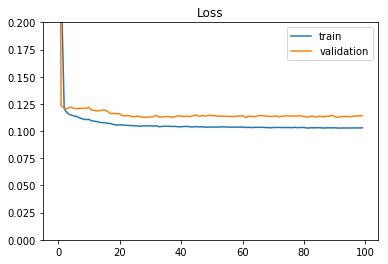

In [109]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.ylim(0, 0.2)
plt.legend(loc='best')
plt.title('Loss');
plt.show()

In [113]:
# pred2 = char2.predict(test_file)
pred2 = char2.predict(train_file)

# print(decode_predictions(pred))

In [114]:
reshaped_pred = np.zeros((289,5,37))
for i in range (289):
    for j in range (5):
        reshaped_pred[i,j] = pred[i,j*37:37*(j+1)]
#         print (reshaped_pred[i,j])
# Il y a bien sur des manières beaucoup plus propre de faire cela mais j'ai déjà eu plusieurs surprises avec le reshape
# Je le fait donc manuell

In [115]:
reshaped_pred2 = np.argmax(reshaped_pred, axis = -1)
print(reshaped_pred2[0])
print(reshaped_pred2[1])
print(reshaped_pred2[2])
print(reshaped_pred2[3])
print(reshaped_pred2[4])
print(reshaped_pred2[5])
print(reshaped_pred2[6])
print(reshaped_pred2[7])

[ 3 14 20 18 36]
[15  4  4 13 13]
[ 0 11  4 29 36]
[ 2  0 18 19 11]
[ 0 13 36 36 36]
[29  8 23 36 36]
[19 14 22 13 36]
[14  5 19  4  4]


In [118]:
print(train_target[0])
print(train_target[1])
print(train_target[2])
print(train_target[3])
print(train_target[4])
print(train_target[5])
print(train_target[6])
print(train_target[7])

[14 20 19 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 8 13  5 14 17 12  0 19  8 14 13 36 36 36 36 36 36 36 36 36 36 36 36]
[13 19 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[22 17 14 23 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 8  3 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 8 13  5 14 17 12  0 19  8 14 13 36 36 36 36 36 36 36 36 36 36 36 36]
[ 7 14 12  4 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 0 17  6 24 11 11 18 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]


In [95]:
print(test_target[0])
print(test_target[1])
print(test_target[2])
print(test_target[3])
print(test_target[4])
print(test_target[5])
print(test_target[6]) 
print(test_target[7])

[ 8 13 19  4 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[17  4  6  8 18 19  4 17  4  3 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 0 13  3 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[ 2  0 18 19 11  4 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[31 35 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[34 34 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[19 14 22 13 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
[11  8  6  7 19 18 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36]
